In [1]:
import os
from dotenv import load_dotenv
from supabase import create_client, Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
# Load environment variables
load_dotenv()

# Initialize Supabase client
url: str = os.environ.get("NEXT_PUBLIC_SUPABASE_URL")
key: str = os.environ.get("NEXT_PUBLIC_SUPABASE_ANON_KEY")
supabase: Client = create_client(url, key)

In [3]:
def fetch_data(tablename, fields):
    try:
        response = supabase.table(tablename).select(','.join(fields)).execute()
        data = response.data
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error fetching data from {tablename}:", str(e))
        return None

# Fetch relevant data
tools_df = fetch_data("tools", ["Tag", "Serial_or_Id_no","Description", "Brand", "Calibrator", "Model_or_Part_No", "Ext_or_Int_Cal"])
measurements_df = fetch_data("measurement_records", ["prod_id", "tool_id", "tool_desc", "measurement_mm", "timestamp"])
calibrations_df = fetch_data("calibration_records", ["Description", "Serial_or_Id_no", "last_calibration_date", "Calibration_error"])
products_df = fetch_data("products", ["serial_id", "size_mm", "tolerance_limit_mm"])
# Display the first few rows of each dataset
print("Tools Dataset:")
print(tools_df.head())
print("\nMeasurements Dataset:")
print(measurements_df.head())
print("\nCalibrations Dataset:")
print(calibrations_df.head())
print("\nProducts Dataset:")
print(products_df.head())


Tools Dataset:
   Tag Serial_or_Id_no           Description      Brand     Calibrator  \
0               264988      Blade Micrometer  Hengliang      OrchidCal   
1               267754      Blade Micrometer  Hengliang  Key Solutions   
2  NIL        81052170       Dial Comparator       MAHR      OrchidCal   
3  NIL          126881  Dial Push Pull Gauge      AIKOH  Key Solutions   
4             22050743  Dial Test Indicators       MAHR  Key Solutions   

  Model_or_Part_No Ext_or_Int_Cal  
0         691-101A            Lab  
1         691-102A            Lab  
2           865 SE            Lab  
3         ANF-500N            Lab  
4  MarTest 800 SGM            Lab  

Measurements Dataset:
     prod_id    tool_id          tool_desc  measurement_mm  \
0  BSH-00001  I91310324  (3.D.1) Flowmeter      186.438528   
1  BSH-00001  I91310324  (3.D.1) Flowmeter      189.927822   
2  BSH-00001  I91310324  (3.D.1) Flowmeter      189.128928   
3  BSH-00001  I91310324  (3.D.1) Flowmeter      188.5

In [4]:
tools_df = tools_df.rename(columns={"Description": "tool_desc", "Serial_or_Id_no": "tool_id"})
merged_df = measurements_df.merge(tools_df, on=["tool_desc", "tool_id"], how="left")
calibrations_df = calibrations_df.rename(columns={"Description": "tool_desc", "Serial_or_Id_no": "tool_id"})
merged_df = merged_df.merge(calibrations_df, on=["tool_desc", "tool_id"], how="left")
products_df = products_df.rename(columns={"serial_id": "prod_id"})
merged_df = merged_df.merge(products_df, on="prod_id", how="left")

merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

merged_df['measurement_error_boolean'] = (merged_df['measurement_mm'] > merged_df['size_mm'] + merged_df['tolerance_limit_mm']) | \
                               (merged_df['measurement_mm'] < merged_df['size_mm'] - merged_df['tolerance_limit_mm'])

merged_df['measurement_difference_mm'] = merged_df.apply(lambda row:
    row['measurement_mm'] - (row['size_mm']) if row['measurement_mm'] > row['size_mm']
    else row['measurement_mm'] - (row['size_mm']) if row['measurement_mm'] < row['size_mm']
    else 0, axis=1)

merged_df.head()

,prod_id,tool_id,tool_desc,measurement_mm,timestamp,Tag,Brand,Calibrator,Model_or_Part_No,Ext_or_Int_Cal,last_calibration_date,Calibration_error,size_mm,tolerance_limit_mm,measurement_error_boolean,measurement_difference_mm
0,BSH-00001,I91310324,(3.D.1) Flowmeter,186.438528,2025-02-28 16:55:00+00:00,Asset No: 100624.3,AW-LAKE,Key Solutions,B4A-6HC-30 (¾” NPT (Female)),Lab,2025-01-18,0.48,188.6,1.8,True,-2.161472
1,BSH-00001,I91310324,(3.D.1) Flowmeter,189.927822,2025-02-28 16:50:00+00:00,Asset No: 100624.3,AW-LAKE,Key Solutions,B4A-6HC-30 (¾” NPT (Female)),Lab,2025-01-18,0.48,188.6,1.8,False,1.327822
2,BSH-00001,I91310324,(3.D.1) Flowmeter,189.128928,2025-02-28 16:45:00+00:00,Asset No: 100624.3,AW-LAKE,Key Solutions,B4A-6HC-30 (¾” NPT (Female)),Lab,2025-01-18,0.48,188.6,1.8,False,0.528928
3,BSH-00001,I91310324,(3.D.1) Flowmeter,188.502335,2025-02-28 16:40:00+00:00,Asset No: 100624.3,AW-LAKE,Key Solutions,B4A-6HC-30 (¾” NPT (Female)),Lab,2025-01-18,0.48,188.6,1.8,False,-0.097665
4,BSH-00001,I91310324,(3.D.1) Flowmeter,188.473537,2025-02-28 16:35:00+00:00,Asset No: 100624.3,AW-LAKE,Key Solutions,B4A-6HC-30 (¾” NPT (Female)),Lab,2025-01-18,0.48,188.6,1.8,False,-0.126463


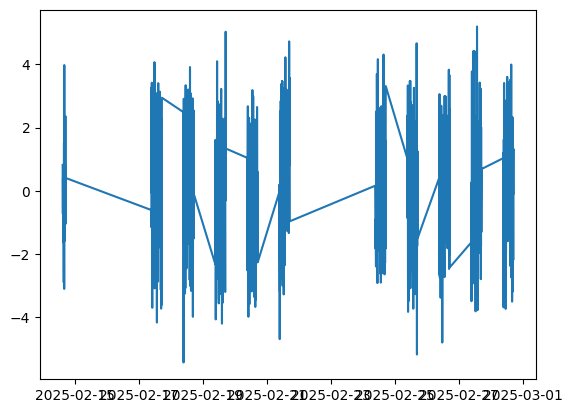

In [5]:
plt.figure()
plt.plot(merged_df["timestamp"], merged_df["measurement_difference_mm"])

In [6]:
# Assuming merged_df is your dataframe, and 'measurement_difference_mm' is the target variable
look_back = 10  # Number of previous time steps to use as features

# Prepare the data with a sliding window approach (look_back)
X, y = [], []
for i in range(look_back, len(merged_df)):
    X.append(merged_df['measurement_difference_mm'].iloc[i-look_back:i])  # Use last 'look_back' observations
    y.append(merged_df['measurement_difference_mm'].iloc[i])  # The value to predict

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [7]:
# Reshape X_train and X_test to the correct format for XGBoost
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Train XGBoost model with default parameters (no fine-tuning)
model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)

# Make predictions
predictions_xgb = model_xgb.predict(X_test)

# Evaluate the model (Mean Squared Error)
mse_xgb = mean_squared_error(y_test, predictions_xgb)
print(f"XGBoost Mean Squared Error: {mse_xgb}")


XGBoost Mean Squared Error: 3.384463620766578


In [17]:
merged_df.columns


Index(['prod_id', 'tool_id', 'tool_desc', 'measurement_mm', 'timestamp', 'Tag',
       'Brand', 'Calibrator', 'Model_or_Part_No', 'Ext_or_Int_Cal',
       'last_calibration_date', 'Calibration_error', 'size_mm',
       'tolerance_limit_mm', 'measurement_error_boolean',
       'measurement_difference_mm'],
      dtype='object')

In [14]:
# Get the forecasted dates based on the last date in the dataset
last_date = merged_df['timestamp'].iloc[train_size - 1]
forecast_dates = pd.date_range(last_date, periods=len(y_test) + 1, freq='D')[1:]

# Create a DataFrame to show the forecasted values with dates
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': predictions_xgb})
forecast_df['Tool_ID'] = merged_df['tool_id'].iloc[train_size - 1]  # Assign Tool_ID for plotting

forecast_df['Upper Bound'] = np.nan
forecast_df['Lower Bound'] = np.nan

for tool_id in forecast_df['Tool_ID'].unique():
    # Filter merged_df for the current tool
    tool_data = merged_df[merged_df['tool_id'] == tool_id]

    # Calculate upper and lower bounds for this tool
    upper_bound = tool_data['tolerance_limit_mm'].iloc[0]  # Assuming the tolerance_limit_mm is the same for all timestamps
    lower_bound = -upper_bound  # Lower bound is negative of the upper bound

    # Apply upper and lower bounds to the forecast_df for this tool
    forecast_df.loc[forecast_df['Tool_ID'] == tool_id, 'Upper Bound'] = upper_bound
    forecast_df.loc[forecast_df['Tool_ID'] == tool_id, 'Lower Bound'] = lower_bound
    forecast_df['Calibration Needed'] = False
    # Check if recalibration is needed (if the forecast is outside of the bounds)
    forecast_df.loc[(forecast_df['Tool_ID'] == tool_id) &
                     ((forecast_df['Forecast'] > upper_bound) | (forecast_df['Forecast'] < lower_bound)), 'Calibration Needed'] = True


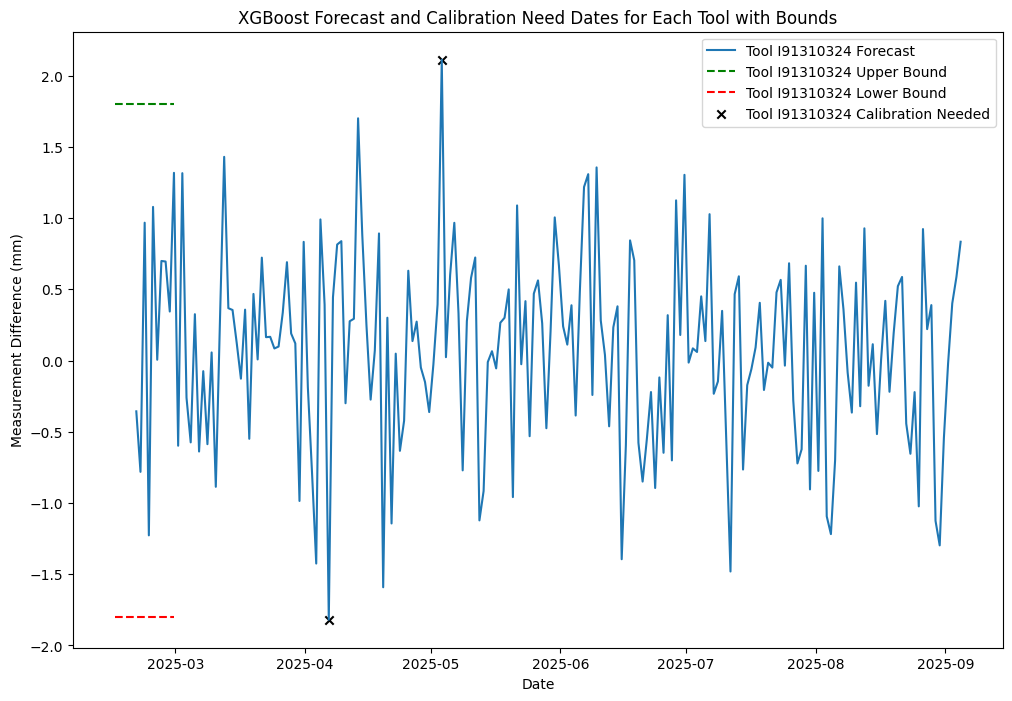

In [15]:
# Visualize the forecasted values, upper and lower bounds, and the dates requiring recalibration for all tools
plt.figure(figsize=(12, 8))

for tool_id in forecast_df['Tool_ID'].unique():
    tool_forecast = forecast_df[forecast_df['Tool_ID'] == tool_id]
    calibration_needed_dates = tool_forecast[tool_forecast['Calibration Needed']]['Date']

    # Get the relevant data from merged_df for the upper and lower bounds
    tool_data = merged_df[merged_df['tool_id'] == tool_id]

    # Ensure we get the tolerance_limit_mm values for the forecast period
    tool_data_sorted = tool_data.sort_values('timestamp')  # Ensure data is sorted by timestamp

    # Calculate the upper and lower bounds
    upper_bounds = tool_data_sorted['tolerance_limit_mm']
    lower_bounds = -upper_bounds  # Lower bound is the negative of the upper bound

    # Plot the forecast for this tool
    plt.plot(tool_forecast['Date'], tool_forecast['Forecast'], label=f'Tool {tool_id} Forecast')

    # Plot the upper and lower bounds for this tool
    plt.plot(tool_data_sorted['timestamp'], upper_bounds, label=f'Tool {tool_id} Upper Bound', color='green', linestyle='--')
    plt.plot(tool_data_sorted['timestamp'], lower_bounds, label=f'Tool {tool_id} Lower Bound', color='red', linestyle='--')

    # Highlight the dates when recalibration is needed
    plt.scatter(calibration_needed_dates, tool_forecast.loc[tool_forecast['Calibration Needed'], 'Forecast'],
                label=f'Tool {tool_id} Calibration Needed', marker='x', color='black')

plt.xlabel('Date')
plt.ylabel('Measurement Difference (mm)')
plt.title('XGBoost Forecast and Calibration Need Dates for Each Tool with Bounds')
plt.legend()
plt.show()


In [16]:
model_xgb.save_model('xgboost_scheduler_v1.json')
